In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

**Class: OU processes**

In [2]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

Variational inference: KL

In [31]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha, self.beta, self.sigma = torch.tensor([ou.alpha, ou.beta, ou.sigma])
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma = self.alpha, self.beta, self.sigma

        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func_kl = vmap(lambda z: z ** 2)
        return ((beta ** 2) - 1 ) / 2  * torch.trapezoid(abs(func_kl(self.ou.trj)), x=self.ou.pts)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma = self.alpha, self.beta, self.sigma
        z0 = self.ou.z0
        z1 = self.ou.trj[-1]
        t0 = self.ou.t0
        t1 = self.ou.t1
        
        # Obtain the rest 
        def A(u):
            return (u ** 2) / 2
        
        return (1 + beta) * (A(z1) - A(z0) - ((t1 - t0) / 2))
    
    def log_prob(self, obs):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
        """
        def log_pdf(obs, z):
            return ss.norm.logpdf(obs, loc=z, scale=.001)
            
        
        return log_pdf(obs, self.ou.trj[-1])


In [32]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, beta):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        beta = Variable(beta, requires_grad=True)
        alpha = torch.tensor(self.ou.alpha)
        sigma = torch.tensor(self.ou.sigma)
        dt = self.ou.dt
        X = self.ou.trj
        
        def compute_transition(X, dt, alpha, beta, sigma):
            """
            Compute the transition density of the (simulated) path
            """
            term1 = -1/2 * (2 * torch.log(sigma) - torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
            term2 = -1 * beta * (X[1:] - alpha - (X[:-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))

            return torch.sum(term1 + term2/term3)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma)
        
        NLL.backward()
         
        return {'beta':beta.grad.detach().clone()}


In [33]:
class MLE:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, beta):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        alpha = torch.tensor(self.ou.alpha)
        sigma = torch.tensor(self.ou.sigma)
        beta = Variable(beta, requires_grad=True)
        dt = self.ou.dt
        X = self.ou.trj

        def compute_transition(X, dt, alpha, beta, sigma):
            """
            Compute the transition density of the (simulated) path
            """
            term1 = -1/2 * (- torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
            term2 = -1 * beta * (X[1:] - alpha - (X[:-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))

            return torch.sum(term1 + term2/term3)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma)
        
        NLL.backward()
        
        return {'beta':beta.grad.detach().clone()}
    
    def LLN(self, beta):
        alpha = torch.tensor(self.ou.alpha)
        sigma = torch.tensor(self.ou.sigma)
        beta = torch.tensor(beta)
        dt = self.ou.dt
        X = self.ou.trj
        """
        Compute the transition density of the (simulated) path
        """
        term1 = -1/2 * ( - torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
        term2 = -1 * beta * (X[1:] - alpha - (X[:-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
        term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))

        return torch.sum(term1 + term2/term3)

**Generate observations from Gaussian likelihood**

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [12]:
true_sde = OU(t0 = 0, t1 = 10., z0 = -1, alpha = 0, beta = 5., sigma = 1., dN=1000)

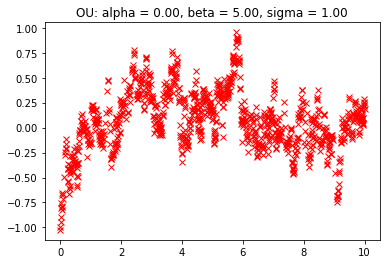

In [13]:
plt.plot(true_sde.pts, true_sde.trj, 'rx')
plt.title("OU: alpha = %.2f" % true_sde.alpha + ", beta = %.2f" % true_sde.beta + ", sigma = %.2f" % true_sde.sigma)
plt.show()

In [14]:
obs = np.random.normal(loc = true_sde.trj[::100], scale = .001)
obs_time = true_sde.pts[::100]

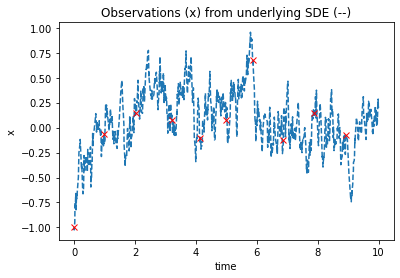

In [15]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts, true_sde.trj, '--')
plt.plot(true_sde.pts[::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [74]:
import tqdm as tq

In [75]:
beta_ = 2.

N = 50
learning_rate = 0.00001

trace_beta = []
trace_elbo = []
for i in tq.tqdm(range(1000)):
# for i in range(300):
    beta_grad = 0.

    for i in range(N):
        vi = OU(t0 = obs_time[8], t1 = obs_time[9], z0 = obs[8], alpha = 0 , beta = beta_ , sigma = 1., dN=30)
        elbo = ELBO(vi)
        score = Score(vi)
        
        scores = score.compute_score(torch.tensor(beta_, dtype=torch.float64))
        f_of_X = -1 * (elbo.log_prob(obs[9]) + elbo.KL_ito() + elbo.KL_rest())
        beta_grad += f_of_X * scores['beta']
     
    beta_ -= learning_rate * (beta_grad/N).numpy()
    
    elbo_estimate = 0
    for j in range(50):
        vi_ = OU(t0 = obs_time[8], t1=obs_time[9], z0 = obs[8], alpha = 0 , beta = beta_ , sigma = 1., dN=30)
        elbo_ = ELBO(vi_)
        elbo_estimate += -1 * (elbo_.log_prob(obs[9]) + elbo_.KL_ito() + elbo_.KL_rest())
    
    elbo_estimate *= 1/100
    
    trace_beta.append(beta_)
    trace_elbo.append(elbo_estimate)
# score.compute_score()

100%|██████████████████████████████████████████████| 1000/1000 [04:39<00:00,  3.57it/s]


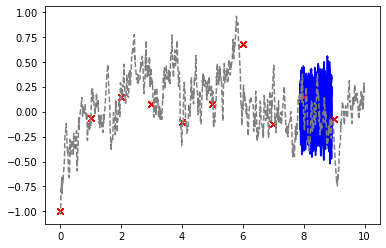

In [76]:
for i in range(50):
    posterior = OU(t0 = obs_time[8], t1 = obs_time[9], z0 = obs[8], alpha = 0 , beta = beta_ , sigma = 1., dN=100)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

**Trace plot: gradient**

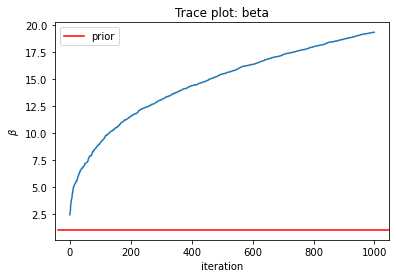

In [77]:
plt.title("Trace plot: beta")
plt.plot(np.arange(len(trace_beta)), trace_beta)
plt.axhline(1.0, xmin=0.01, xmax=300, color='red', label='prior')
plt.legend()
plt.xlabel("iteration")
plt.ylabel(r"$\beta$")
plt.show()

Trace plot: ELBO

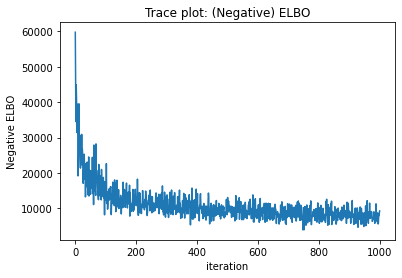

In [80]:
plt.title("Trace plot: (Negative) ELBO")
plt.plot(np.arange(len(trace_elbo)), trace_elbo)
plt.xlabel("iteration")
plt.ylabel("Negative ELBO")
plt.show()

**Posterior moment based on the average of last 30 iterations of beta**

In [81]:
def posterior_moment(init, alpha, beta):
    sigma = 1.
    pts = np.linspace(0,1,100)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
        
    for i in range(dt.shape[0]):
        mean.append(alpha + (mean[i] - alpha)*np.exp(-1 * beta * dt[i]))
    
    func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
    sd = list(map(func, dt))
    
    return np.array(mean), np.array(sd)

In [84]:
pmean, psd = posterior_moment(obs[8], 0, beta_)

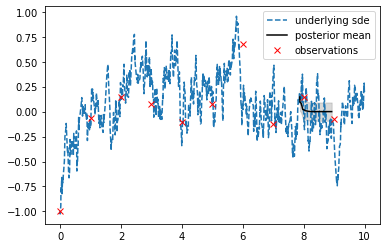

In [96]:
plt.plot(true_sde.pts, true_sde.trj, linestyle='dashed', label='underlying sde')
plt.plot(true_sde.pts[800:900], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[801:900], pmean[1:] - psd, pmean[1:] + psd, alpha=0.3, color='grey')
plt.plot(obs, 'rx', label='observations')
plt.legend()
plt.show()

2. Complete piece-wise optimization from t=0 to t=10

We use the posterior mean of the previous step as our initial value for next vi

In [159]:
N = 50
N_e = 50
learning_rate = 0.00002
z0 = obs[0]
vi_beta = np.empty(9)
IT = 300

elbo_traces = np.empty((9, IT))
beta_traces = np.empty((9, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    beta_ = np.random.uniform(0, 1)
    
    trace = []
    for i in range(IT):
        beta_grad = 0.
            
        for k in range(N):
            vi = OU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0, alpha = 0 , beta = beta_ , sigma = 1., dN=30)
            elbo = ELBO(vi)
            score = Score(vi)

            scores = score.compute_score(torch.tensor(beta_, dtype=torch.float64))
            f_of_X = -1 * (elbo.log_prob(obs[t+1]) + elbo.KL_ito() + elbo.KL_rest())
            
            beta_grad += f_of_X * scores['beta']

        beta_ -= learning_rate * (beta_grad/N).numpy()
        beta_traces[t, i] = beta_
        
        elbo_estimate = 0
        for j in range(N_e):
            vi_ = OU(t0 = obs_time[t], t1=obs_time[t+1], z0 = z0, alpha = 0 , beta = beta_ , sigma = 1., dN=30)
            elbo_ = ELBO(vi_)
            elbo_estimate += -1 * (elbo_.log_prob(obs[t+1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
        elbo_estimate *= 1/N_e
        if i % 100 == 0:
            print("beta = ", beta_, "elbo = ", elbo_estimate)
        elbo_traces[t, i] = elbo_estimate

    vi_beta[t] = np.mean(beta_traces[t, -30:])
    
    z0 *= np.exp(-1 * vi_beta[t] * (obs_time[t+1] - obs_time[t]))
    
# score.compute_score()

  0%|                                                            | 0/9 [00:00<?, ?it/s]

beta =  6.484732331818223 elbo =  tensor(57462.5135)
beta =  12.378559625054487 elbo =  tensor(24057.6436)
beta =  15.204733654650104 elbo =  tensor(21657.1597)


 11%|█████▊                                              | 1/9 [01:23<11:05, 83.23s/it]

beta =  6.456870829891135 elbo =  tensor(48975.4910)
beta =  11.965992057137605 elbo =  tensor(27218.7158)
beta =  14.2337773133913 elbo =  tensor(27769.7377)


 22%|███████████▌                                        | 2/9 [02:47<09:45, 83.60s/it]

beta =  7.11030141130386 elbo =  tensor(50224.1292)
beta =  12.013402948207938 elbo =  tensor(31960.6809)
beta =  14.805870386686724 elbo =  tensor(20600.8104)


 33%|█████████████████▎                                  | 3/9 [04:10<08:22, 83.73s/it]

beta =  13.643087586435389 elbo =  tensor(18520.0526)
beta =  15.834479637307648 elbo =  tensor(24274.0364)
beta =  17.472586377431956 elbo =  tensor(21427.8893)


 44%|███████████████████████                             | 4/9 [05:35<07:00, 84.19s/it]

beta =  7.975082736724646 elbo =  tensor(26953.4790)
beta =  12.635277361566168 elbo =  tensor(14898.4412)
beta =  15.438301690619857 elbo =  tensor(21812.4636)


 56%|████████████████████████████▉                       | 5/9 [06:59<05:36, 84.04s/it]

beta =  5.025765494236156 elbo =  tensor(352648.0385)
beta =  11.125637628798097 elbo =  tensor(257197.2495)
beta =  14.618204040496044 elbo =  tensor(240522.4016)


 67%|██████████████████████████████████▋                 | 6/9 [08:25<04:14, 84.71s/it]

beta =  5.882060298634524 elbo =  tensor(49110.3884)
beta =  11.918028224606827 elbo =  tensor(22720.7968)
beta =  14.519897844389236 elbo =  tensor(21591.8411)


 78%|████████████████████████████████████████▍           | 7/9 [09:51<02:50, 85.21s/it]

beta =  7.104182453042047 elbo =  tensor(47728.6351)
beta =  12.835096091829746 elbo =  tensor(32146.2314)
beta =  15.31734162082746 elbo =  tensor(23952.3354)


 89%|██████████████████████████████████████████████▏     | 8/9 [11:16<01:25, 85.02s/it]

beta =  4.173886156508265 elbo =  tensor(49201.6119)
beta =  11.547344501369276 elbo =  tensor(26349.1445)
beta =  14.54971776721497 elbo =  tensor(18760.3070)


100%|████████████████████████████████████████████████████| 9/9 [12:42<00:00, 84.72s/it]


Trace plot: ELBO

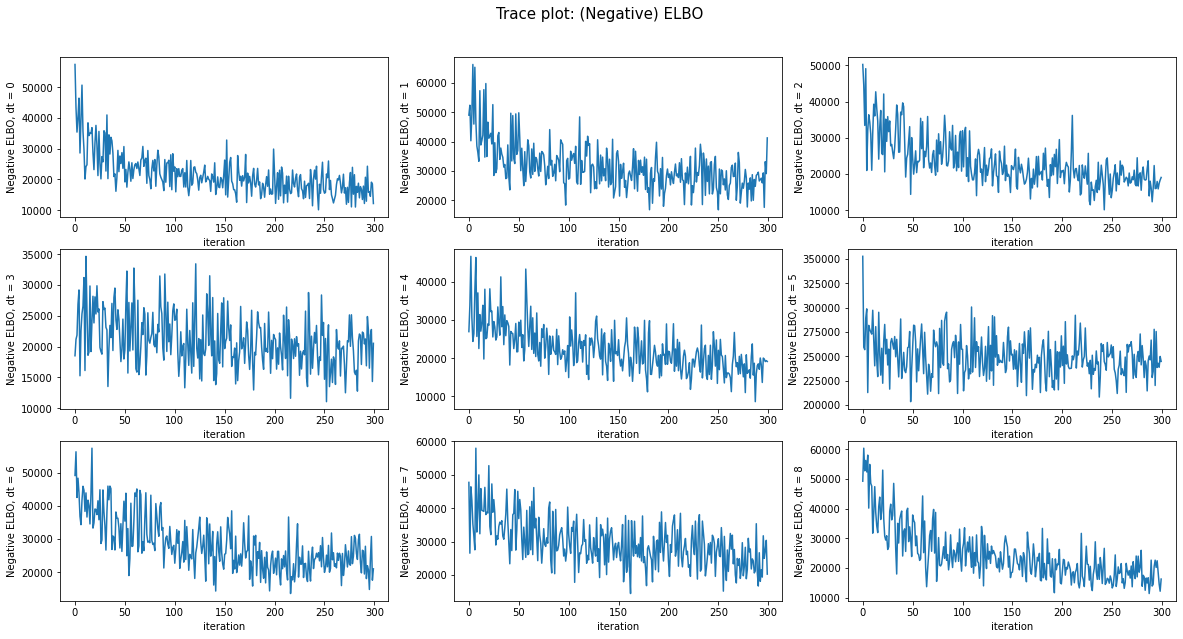

In [249]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :IT])), elbo_traces[t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

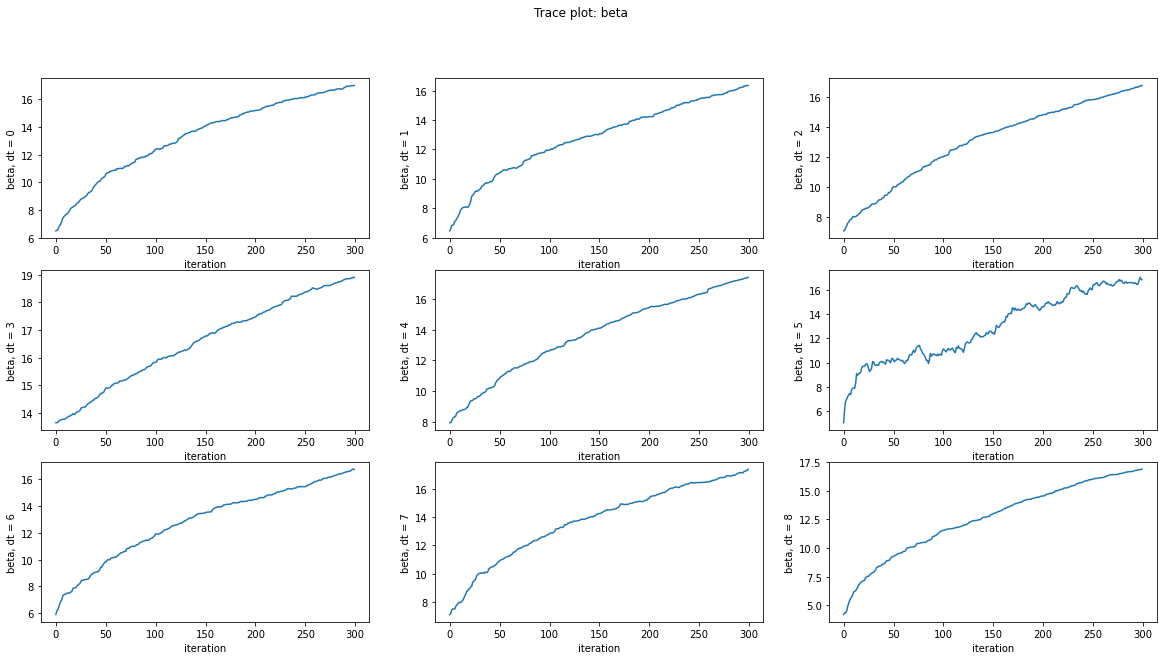

In [169]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(beta_traces[t, :IT])), beta_traces[t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("beta, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: beta")
plt.show()

In [244]:
def g_posterior_moment(init, alpha, vi_beta, t0, t1):
    """
        Obtain credible interval
            posterior mean and variance are computed based on the theory (using fitted variational parameter at each interval)
    """
    sigma = 1.
    pts = np.linspace(t0,t1,900)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
    var = list(map(lambda t: np.sqrt((sigma ** 2 / (2*vi_beta[0])) * (1 - np.exp(-2 * vi_beta[0] * t))), dt[:100]))
    
    k = 0
    for j in range(dt.shape[0]):
        if j % 100 == 0:
            beta = vi_beta[k]
            k += 1
        mean.append(alpha + (mean[j] - alpha)*np.exp(-1 * beta * dt[j]))
        if (j % 100 == 0) and (j > 0):
            func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
            var += list(map(func, dt[j-100:j]))
    return np.array(mean), np.array(var)

In [245]:
pmean, pvar = g_posterior_moment(obs[0], 0, vi_beta, 0, 10)

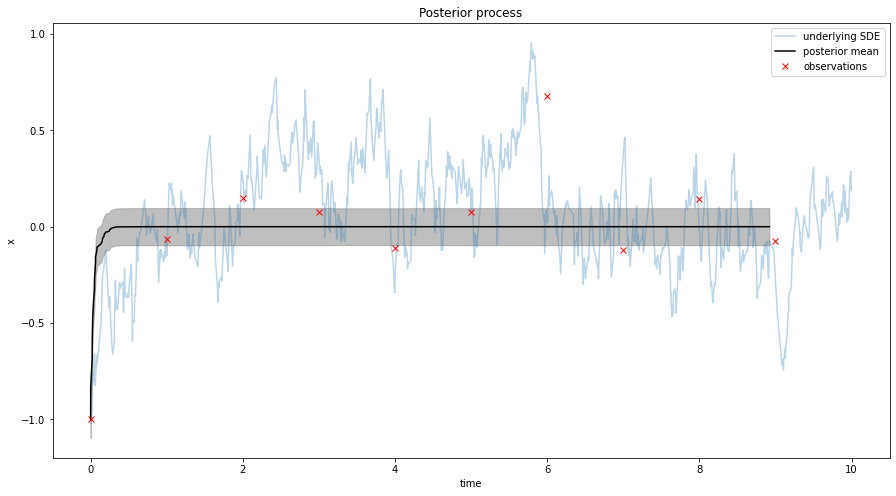

In [246]:
plt.figure(figsize=(15,8))
plt.title("Posterior process")
plt.plot(true_sde.pts, true_sde.trj, alpha=0.3, label='underlying SDE')
plt.plot(true_sde.pts[:900], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[:900], pmean - pvar, pmean + pvar, alpha=0.5, color='grey')
plt.plot(obs, 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Sanity check: score function**
This code is to examine whether the gradient descent with the above score class gives a plausible MLE 

In [34]:
torch.set_default_dtype(torch.float64)

In [9]:
true_sde = OU(t0 = 0, t1 = 10., z0 = 0., alpha = 0, beta = 0.08, sigma = 1., dN=30)

In [11]:
beta_ = torch.tensor([1.5])

for i in range(10000):
    mle = MLE(true_sde)
    update = mle.compute_score(beta = beta_)['beta']
    beta_ += 0.0001 * update
    if i % 1000 == 0:
        print("beta = ", beta_)
        print("MLE = ", mle.LLN(beta_))

beta =  tensor([1.4968])
MLE =  tensor(-24.2828)


/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_80235/4072351254.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(beta)


beta =  tensor([0.2179])
MLE =  tensor(-0.9550)
beta =  tensor([0.1184])
MLE =  tensor(-0.8041)
beta =  tensor([0.1114])
MLE =  tensor(-0.8033)
beta =  tensor([0.1109])
MLE =  tensor(-0.8033)
beta =  tensor([0.1109])
MLE =  tensor(-0.8033)
beta =  tensor([0.1109])
MLE =  tensor(-0.8033)
beta =  tensor([0.1109])
MLE =  tensor(-0.8033)
beta =  tensor([0.1109])
MLE =  tensor(-0.8033)
beta =  tensor([0.1109])
MLE =  tensor(-0.8033)
